In [1]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger(__name__)

from divertor_spectroscopy import analysis
from divertor_spectroscopy.spectrum_models import ip320_cw_404_HgAr_calibration
from divertor_spectroscopy.spectrum_models import synthetic_spectrum
from divertor_spectroscopy.spectrum_models import ip320_cw_405_reduced_Balmer_delta
from divertor_spectroscopy import instrument
from divertor_spectroscopy import utilities as utils
from divertor_spectroscopy import spectrum
from divertor_spectroscopy import atomic_data
from divertor_spectroscopy import wavelength_calibration
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = colors + colors[1:]
fontsize = 14
plt.rcParams.update({'font.size': fontsize})

### Why am I making a big deal out of the instrument functions?
- the easies way to use an instrument function is to define it as gaussian and therefore symmetrical. With calibration measurments the width of these instrument functions can be applied. This is robust and simple and therefore used for most automated analysis
- usually instrument functions are not gaussian and therefore need to be implemented numerically
- I had some trouble using the convolutions and therefore this needs to be tested/documented properly

### What is this notebook going to do?
- we are taking the most standard case (IP320) and producing synthetic spectra and benchmark the numerical against the gaussian instrument function
    - Start with symmetrical instrument function
        - intensity fits, wavelength calibration
    - Synthetic non symmetrical instrument function
        - intensity fits, wavelength calibration

### IP320

In [2]:
IP320 = {}
IP320["pixels"] = 1024
x_wl = np.linspace(-511.5,511.5,1024)
wavelength_coefficients = [405,-0.019,-3e-7]
wavelength = utils.polynominal(x_wl,*wavelength_coefficients)
IP320["wavelength"] = np.linspace(395,415,1024)
IP320["width"] = 0.03
IP320["dispersion"] = np.abs(IP320["wavelength"][0]-IP320["wavelength"][-1])/IP320["pixels"]
x = np.arange(31)
inst_gauss = instrument.Instrument(wavelength=IP320["wavelength"],instrument_function_mode="gauss",width=IP320["width"])
numeric_instrument_function = utils.gauss(x=x,offset=0,position=15,width=0.03/IP320["dispersion"])
inst_numeric = instrument.Instrument(wavelength=IP320["wavelength"],instrument_function_mode="convolution_entire_spectrum",numeric_instrument_function=numeric_instrument_function,width=IP320["width"])
    


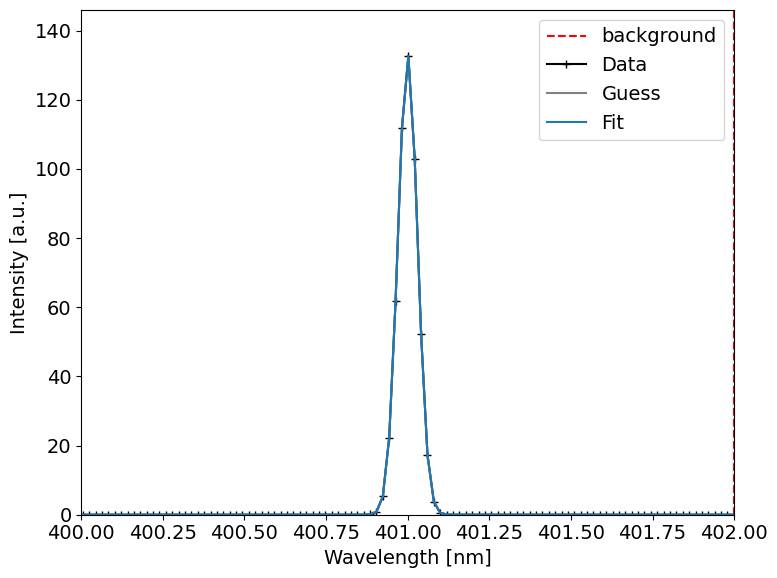

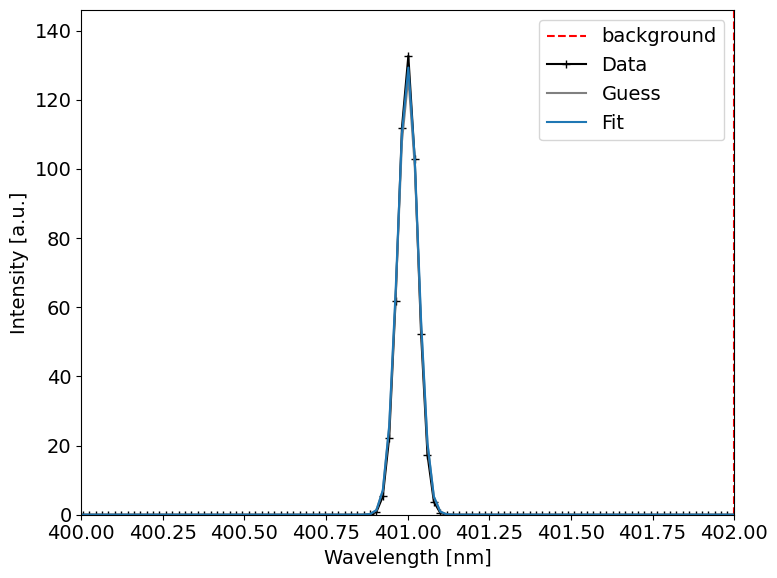

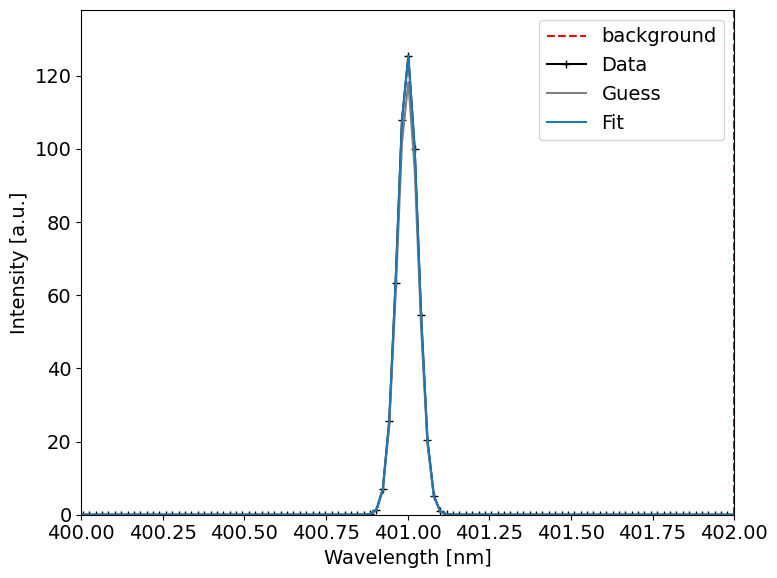

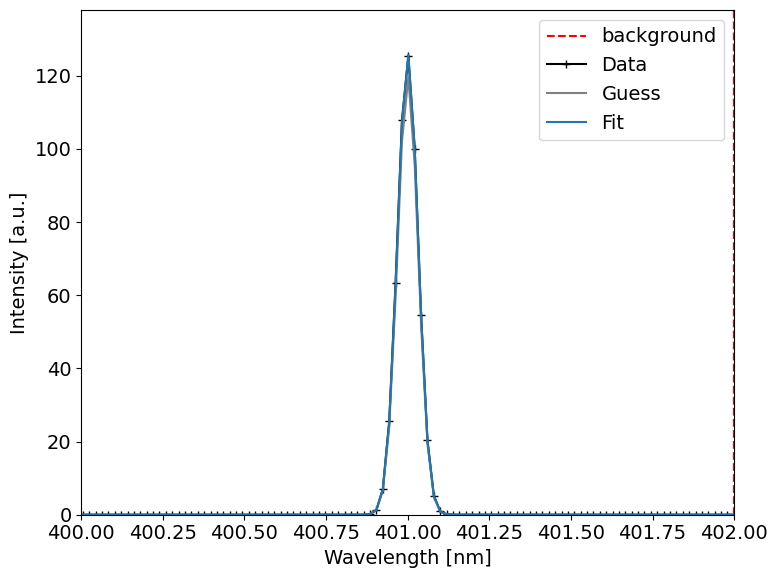

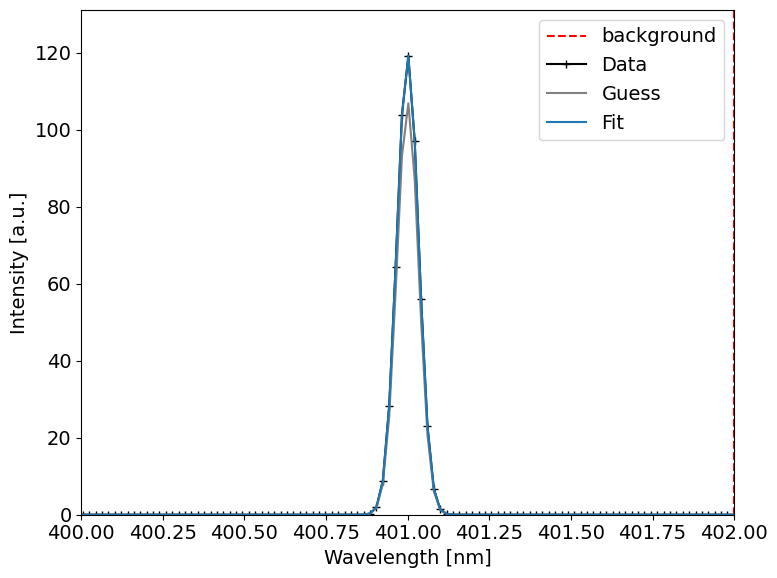

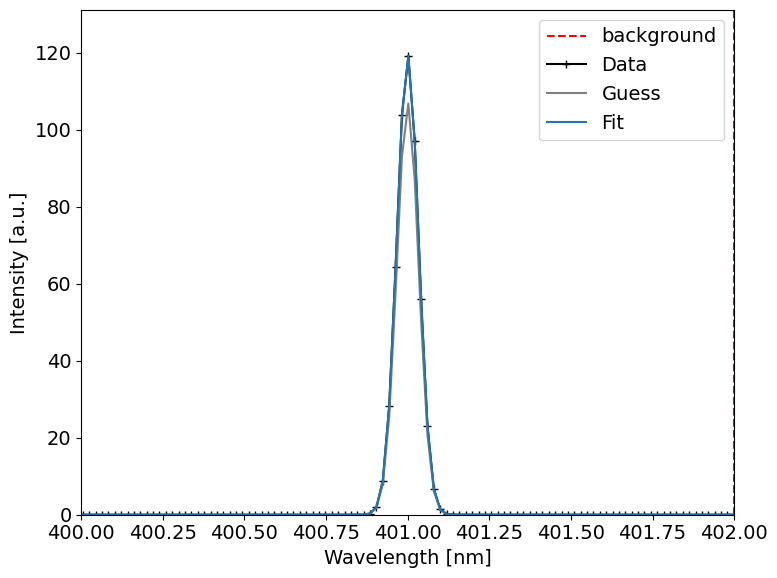

In [3]:
   # Simplest test: compare a spectrum with a central peak with gauss and numeric instrument function
model = synthetic_spectrum.Synthetic_spectrum()
analyse_gauss = analysis.Analysis(model=model,instrument=inst_gauss)
analyse_numeric = analysis.Analysis(model=model,instrument=inst_numeric)
fit_parameters_gauss = []
fit_parameters_numeric = []

temperatures = np.linspace(0.01,5,3)
params = np.array([1])
width_doppler = []
for temperature in temperatures:
    model.multiplets[0].doppler_temperature = temperature
    spectrum_gauss = analyse_gauss.build_spectrum(IP320["wavelength"],params,filter=None)
    width_doppler.append(analyse_numeric.model.multiplets[0].doppler_width)
    analyse_gauss.fit_spectrum(spectrum_gauss)
    analyse_numeric.fit_spectrum(spectrum_gauss)
    fit_parameters_gauss.append(10**params[0]/10**analyse_gauss.fit_parameters[0])
    fit_parameters_numeric.append(10**params[0]/10**analyse_numeric.fit_parameters[0])
    debug = True
    if debug:
        analyse_gauss.display_spectrum(xlim=[400,402])
        analyse_numeric.display_spectrum(xlim=[400,402])
        

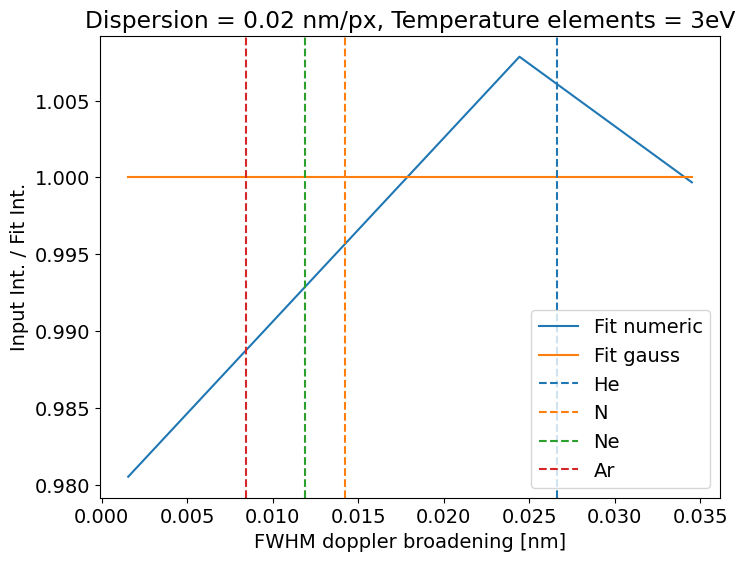

In [4]:
elements = ["He","N","Ne","Ar"]
doppler_broadening_at_3_eV = []
for element in elements:
    mass = atomic_data.get_mass_of_element(element=element)
    broadening = utils.doppler_broadening_nist(T=3,m=mass,lambda_0=399.5)*2.35
    doppler_broadening_at_3_eV.append(broadening)
plt.figure(figsize=(8,6))
plt.title("Dispersion = 0.02 nm/px, Temperature elements = 3eV")
plt.plot(np.array(width_doppler)*2.35,fit_parameters_numeric,label="Fit numeric")
plt.plot(np.array(width_doppler)*2.35,fit_parameters_gauss,label="Fit gauss")
plt.xlabel("FWHM doppler broadening [nm]")
plt.ylabel("Input Int. / Fit Int.")
for i in range(len(elements)):
    plt.axvline(x=doppler_broadening_at_3_eV[i],c=colors[i],linestyle="--",label=elements[i])
plt.legend()
plt.show()

### For our spectrometer it gets accurate at a doppler width of > 0.01 nm

In [5]:
elements = ["H","He","B","C","N","O","Ne","Ar"]
doppler_broadening_at_3_eV = []
for element in elements:
    mass = atomic_data.get_mass_of_element(element=element)
    broadening = utils.doppler_broadening_nist(T=3,m=mass,lambda_0=399.5)
    doppler_broadening_at_3_eV.append(broadening)

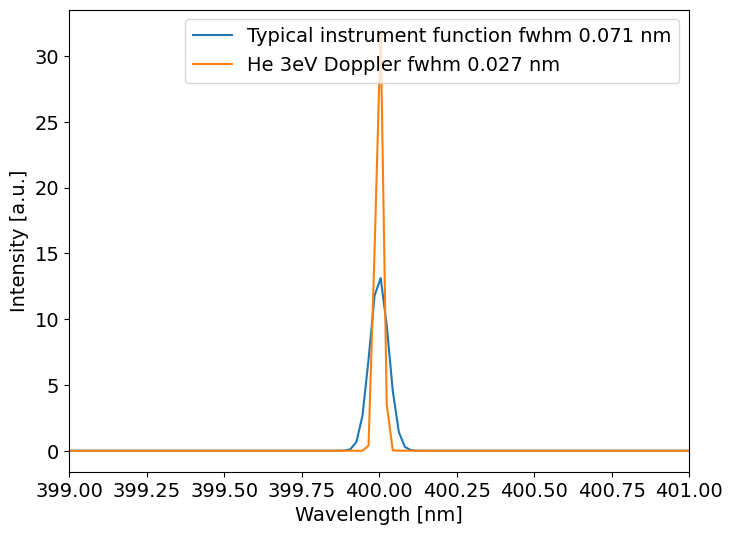

In [6]:
# plot instrument function against and a gaussian with the doppler width to see the difference
plt.figure(figsize=(8,6))

doppler_width_he = 0.0114
instrument_width = 0.03
y_instrument = utils.gauss(x=IP320["wavelength"],offset=0,position=400,intensity=1,width=instrument_width)
y_doppler = utils.gauss(x=IP320["wavelength"],offset=0,position=400,intensity=1,width=doppler_width_he)
plt.plot(IP320["wavelength"],y_instrument,label="Typical instrument function fwhm {:.3f} nm".format(utils.sigma_to_fwhm(instrument_width)))
plt.plot(IP320["wavelength"],y_doppler,label="He 3eV Doppler fwhm {:.3f} nm".format(utils.sigma_to_fwhm(doppler_width_he)))
plt.xlim(399,401)
plt.legend()
plt.xlabel("Wavelength [nm]")
plt.ylabel("Intensity [a.u.]")
plt.show()

### Next Step: Wavelength calibration
- Use the Hg spectrum but make it very hot to avoid the problems
- implement finer convolution to avoid problem

None
0.03


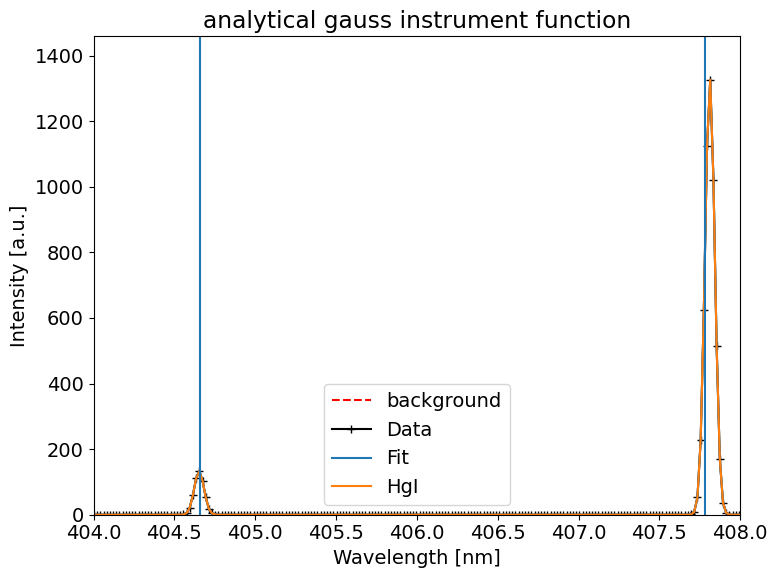

[4.05000000e+02 1.95503421e-02 1.00000000e+00 2.00000000e+00]
[405, 0.01975]
[5.07860216e-22 2.37069208e-19 7.24316048e-17 1.44844854e-14
 1.89583281e-12 1.62412332e-10 9.10667785e-09 3.34212699e-07
 8.02801037e-06 1.26216143e-04 1.29880481e-03 8.74772002e-03
 3.85627382e-02 1.11266098e-01 2.10126028e-01 2.59728047e-01
 2.10126028e-01 1.11266098e-01 3.85627382e-02 8.74772002e-03
 1.29880481e-03 1.26216143e-04 8.02801037e-06 3.34212699e-07
 9.10667785e-09 1.62412332e-10 1.89583281e-12 1.44844854e-14
 7.24316048e-17 2.37069208e-19 5.07860216e-22]
0.03


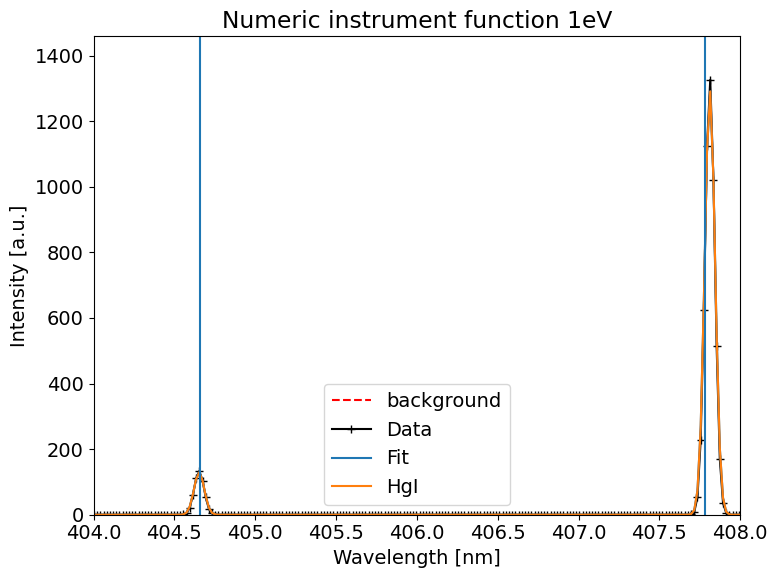

[4.04999874e+02 1.95523525e-02 1.00876518e+00 2.00954577e+00]
[405, 0.01975]
[4.05000000e+02 1.95503421e-02] [4.04999874e+02 1.95523525e-02]


In [7]:
#%matplotlib widget
model = ip320_cw_404_HgAr_calibration.Ip320_cw_404_HgAr_calibration()
params = np.array([1,2])
analyse_gauss = analysis.Analysis(model=model,instrument=inst_gauss)
synthetic_spectrum = analyse_gauss.build_spectrum(IP320["wavelength"],*params,filter=None)
wavelength_coefficients_guess = [405,0.01975]
lower_bounds = [404,0.019]
upper_bounds = [406,0.021]
inst_wl_calibration_gauss = instrument.Instrument(wavelength=IP320["wavelength"],instrument_function_mode="gauss",width=IP320["width"],wavelength_coefficients_guess=wavelength_coefficients_guess,lower_bounds=lower_bounds,upper_bounds=upper_bounds)
coeff_gauss = wavelength_calibration.calibrate_wavelength_using_analysis_class(spectrum=synthetic_spectrum,model=model,title="analytical gauss instrument function",instrument=inst_wl_calibration_gauss,highlight_tags=["HgI"],debug=True,xlim=[404,408])
inst_wl_calibration_numeric = instrument.Instrument(wavelength=IP320["wavelength"],instrument_function_mode="convolution_entire_spectrum",numeric_instrument_function=numeric_instrument_function,width=IP320["width"],wavelength_coefficients_guess=wavelength_coefficients_guess,lower_bounds=lower_bounds,upper_bounds=upper_bounds)
coeff_numeric = wavelength_calibration.calibrate_wavelength_using_analysis_class(spectrum=synthetic_spectrum,title="Numeric instrument function 1eV",model=model,instrument=inst_wl_calibration_numeric,highlight_tags=["HgI"],debug=True,xlim=[404,408])

print(coeff_gauss,coeff_numeric)

### Implement way to make this work also with tiny doppler broadening

### Check Voigt function numerical and analytical

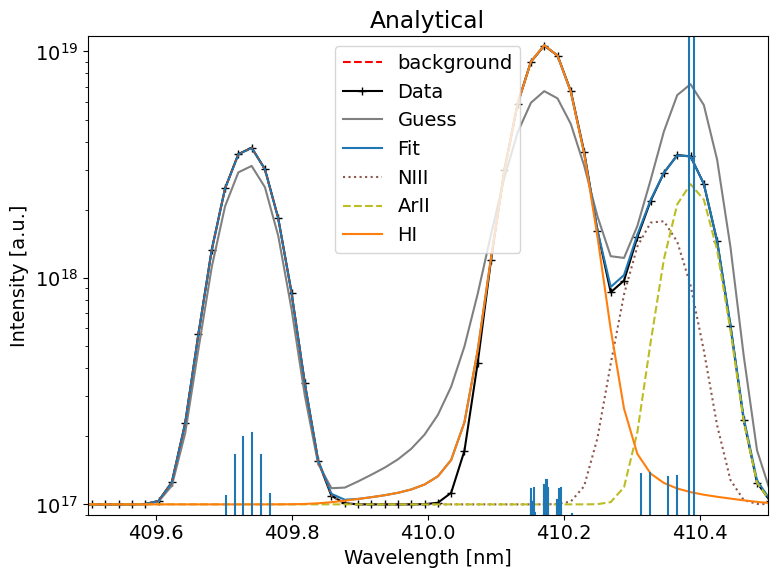

fit_description  fit_parameters  fit_parameters_linear      guess  \
0  Intensity_NIII_409.937       17.697673           4.985092e+17  17.615831   
1  Intensity_ArII_410.383       16.975396           9.449221e+16  17.400599   
2  Intensity_ArII_410.391       17.017515           1.041155e+17  17.400599   
3       Intensity_H_delta       18.004117           1.009524e+18  17.897539   
4   Stark_density_H_delta       19.041416           1.100060e+19  19.698970   

   lower_bounds  upper_bounds  
0     14.143188     19.901655  
1     14.143188     19.901655  
2     14.143188     19.901655  
3     15.266977     19.901655  
4     19.000000     22.000000

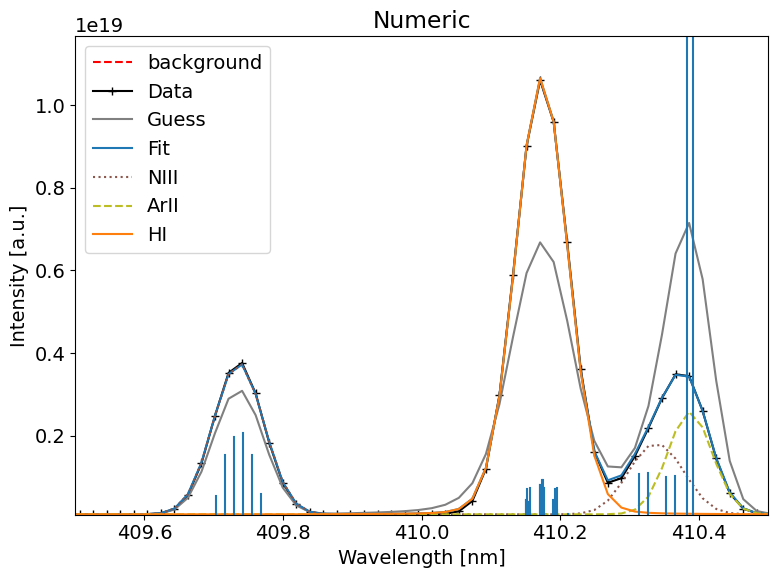

fit_description  fit_parameters  fit_parameters_linear      guess  \
0  Intensity_NIII_409.937       17.699917           5.010915e+17  17.615831   
1  Intensity_ArII_410.383       16.976649           9.476523e+16  17.400599   
2  Intensity_ArII_410.391       17.015161           1.035525e+17  17.400599   
3       Intensity_H_delta       18.003833           1.008865e+18  17.897539   
4   Stark_density_H_delta       19.034859           1.083576e+19  19.698970   

   lower_bounds  upper_bounds  
0     14.143188     19.901655  
1     14.143188     19.901655  
2     14.143188     19.901655  
3     15.266977     19.901655  
4     19.000000     22.000000

In [8]:
if True:
    #%matplotlib widget
    model = ip320_cw_405_reduced_Balmer_delta.Ip320_cw_405_reduced_Balmer_delta(stark_density=True,zeeman=True)
    model_no_stark = ip320_cw_405_reduced_Balmer_delta.Ip320_cw_405_reduced_Balmer_delta(stark_density=False,zeeman=True)
    analyse_no_stark = analysis.Analysis(model=model_no_stark,instrument=inst_gauss)
    analyse_gauss = analysis.Analysis(model=model,instrument=inst_gauss)
    analyse_numeric = analysis.Analysis(model=model,instrument=inst_numeric)
    analyse_no_stark.get_default_fit_parameters()
    params = analyse_no_stark.default_fit_parameters
    synthetic_spectrum = analyse_no_stark.build_spectrum(IP320["wavelength"],*params,filter=None)+1e17
    analyse_gauss.fit_spectrum(synthetic_spectrum)
    xlim = [409.5,410.5]
    analyse_gauss.display_spectrum(xlim=xlim,highlight_tags=model.all_tags,title="Analytical",show_positions=True,scale="log")
    analyse_gauss.format_fit_output()
    display(analyse_gauss.fit_output)
    analyse_numeric.fit_spectrum(synthetic_spectrum)
    analyse_numeric.display_spectrum(xlim=xlim,highlight_tags=model.all_tags,title="Numeric",show_positions=True)
    analyse_numeric.format_fit_output()
    display(analyse_numeric.fit_output)

### I think the problem now was the convolution that failes with the tiny broadening

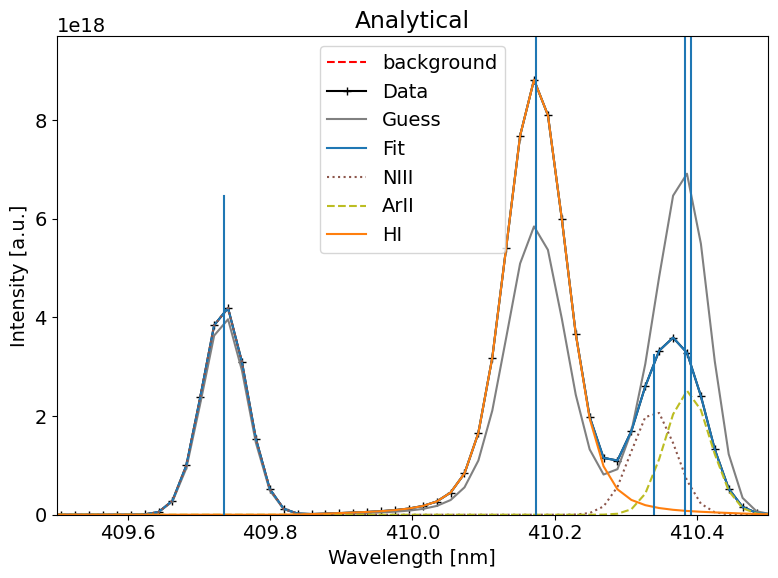

fit_description  fit_parameters  fit_parameters_linear      guess  \
0  Intensity_NIII_409.937        17.69897           5.000000e+17  17.674587   
1  Intensity_ArII_410.383        17.00000           1.000000e+17  17.392513   
2  Intensity_ArII_410.391        17.00000           1.000000e+17  17.392513   
3       Intensity_H_delta        18.00000           1.000000e+18  17.821442   
4   Stark_density_H_delta        19.69897           5.000000e+19  19.698970   

   lower_bounds  upper_bounds  
0     13.805206     19.821442  
1     13.805206     19.821442  
2     13.805206     19.821442  
3     14.928995     19.821442  
4     19.000000     22.000000

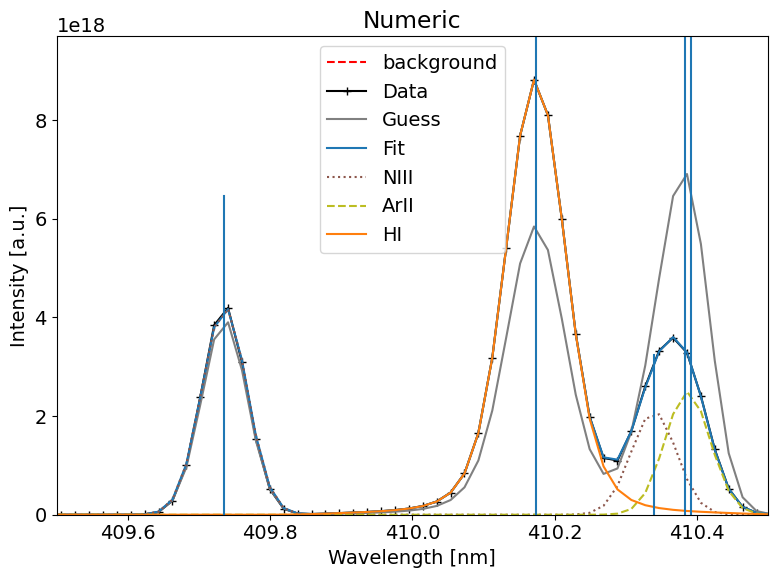

fit_description  fit_parameters  fit_parameters_linear      guess  \
0  Intensity_NIII_409.937       17.703482           5.052213e+17  17.674587   
1  Intensity_ArII_410.383       17.026575           1.063102e+17  17.392513   
2  Intensity_ArII_410.391       16.968266           9.295350e+16  17.392513   
3       Intensity_H_delta       17.999740           9.994006e+17  17.821442   
4   Stark_density_H_delta       19.697022           4.977627e+19  19.698970   

   lower_bounds  upper_bounds  
0     13.805206     19.821442  
1     13.805206     19.821442  
2     13.805206     19.821442  
3     14.928995     19.821442  
4     19.000000     22.000000

In [9]:
if True:
    #%matplotlib widget
    model = ip320_cw_405_reduced_Balmer_delta.Ip320_cw_405_reduced_Balmer_delta(stark_density=True,zeeman=False)
    analyse_gauss = analysis.Analysis(model=model,instrument=inst_gauss)
    analyse_numeric = analysis.Analysis(model=model,instrument=inst_numeric)
    analyse_no_stark.get_default_fit_parameters()
    params = analyse_gauss.default_fit_parameters
    synthetic_spectrum = analyse_gauss.build_spectrum(IP320["wavelength"],*params,filter=None)
    analyse_gauss.fit_spectrum(synthetic_spectrum)
    xlim = [409.5,410.5]
    analyse_gauss.display_spectrum(xlim=xlim,highlight_tags=model.all_tags,title="Analytical",show_positions=True)
    analyse_gauss.format_fit_output()
    display(analyse_gauss.fit_output)
    analyse_numeric.fit_spectrum(synthetic_spectrum)
    analyse_numeric.display_spectrum(xlim=xlim,highlight_tags=model.all_tags,title="Numeric",show_positions=True)
    analyse_numeric.format_fit_output()
    display(analyse_numeric.fit_output)

### My Lomanowskigauss has a real problem
- I suspect there is a shift when convoluting the Lomanowski function
    - reproduce this in a small example

In [10]:
from divertor_spectroscopy import spectrum
class Multiplet(spectrum.Spectrum):
    def __init__(self,zeeman=False):
        self.fit_description = []
        self.multiplets = []
        self.balmer_lines = []
        self.pec_lines = []
        self.all_tags = []
        self.recommended_background_position = 401.7
        if False: # example of a balmer line (hydrogen broadened by stark broadening)
            self.add_balmer_lines_to_model(lines=["H_delta"],intensities=[1e17],doppler_temperature=1,electron_density=5e19,electron_temperature=1,tag="HI",fit_broadening=False)
        if True:
            self.add_multiplet_to_model(positions=[410.1734], branching_ratios=[1], intensity=0.1, doppler_temperature=3, tag="HI")
        self.clear_tag_multiplicity()
class Balmer_line(spectrum.Spectrum):
    def __init__(self,zeeman=False):
        self.fit_description = []
        self.multiplets = []
        self.balmer_lines = []
        self.pec_lines = []
        self.all_tags = []
        self.recommended_background_position = 401.7
        if True: # example of a balmer line (hydrogen broadened by stark broadening)
            self.add_balmer_lines_to_model(lines=["H_delta"],intensities=[.1],doppler_temperature=3,electron_density=5e18,electron_temperature=1,tag="HI",fit_broadening=False)
        if False:
            self.add_multiplet_to_model(positions=[410.1734], branching_ratios=[1], intensity=1e17, doppler_temperature=1, tag="HI")
        self.clear_tag_multiplicity()
        

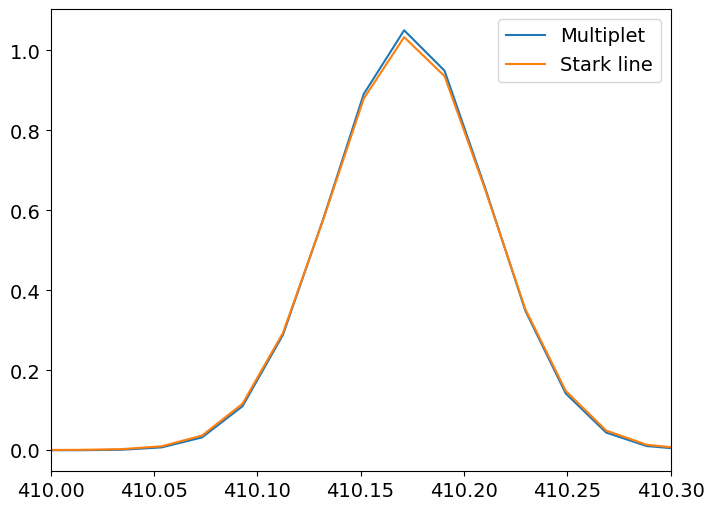

In [11]:
model_multiplet = Multiplet()
analyse_multiplet = analysis.Analysis(model=model_multiplet,instrument=inst_gauss)
analyse_multiplet.get_default_fit_parameters()
params = analyse_multiplet.default_fit_parameters
synthetic_spectrum_multiplet = analyse_multiplet.build_spectrum(IP320["wavelength"],*params,filter=None)
model_balmer = Balmer_line()
analyse_balmer = analysis.Analysis(model=model_balmer,instrument=inst_gauss)
analyse_balmer.get_default_fit_parameters()
params = analyse_balmer.default_fit_parameters
synthetic_spectrum_balmer = analyse_balmer.build_spectrum(IP320["wavelength"],*params,filter=None)
plt.figure(figsize=(8,6))
plt.plot(IP320["wavelength"],synthetic_spectrum_multiplet,label="Multiplet")
plt.plot(IP320["wavelength"],synthetic_spectrum_balmer,label="Stark line")
plt.xlim(410,410.3)
plt.legend()
plt.show()